In [75]:
import numpy as np
import pandas as pd
from enum import Enum, auto
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
from matplotlib import cm
import plotly.graph_objects as go
import plotly.express as px

### Wprowadzenie i kalibracja modelu

Zakładamy
\begin{align*}
S^1_n (\omega) = S^1_0(\omega) \exp (sn + m\sum_{i=1}^n \omega_i) \\
\mathbb{P}(\omega_{i+1} = 1 | \mathcal{F}_i) = p \\
\mathbb{P}(\omega_{i+1} = -1 | \mathcal{F}_i) = 1-p
\end{align*}
Potrzebujemy dobrać odpowiednie s, m, p. 

Oznaczmy

\begin{align*}
R_n (\omega) = \log ( \frac {S_n (\omega)} {S_{n-1}(\omega)} ) = s + m\omega_n
\end{align*}
Przy ustalonym p
\begin{align*}
\mathbb{E}[R_n] = s + m(2p-1)\\
Var(R_n) = 4m^2p (1-p)
\end{align*}
tak więc 
\begin{align*}
m = \sqrt{\frac {Var(R_n)} {4p(1-p)}}\\
s = \mathbb{E}[R_n] - m(2p-1) 
\end{align*}
Tak więc ustalając p jesteśmy w stanie estymować s i m korzystając ze zwrotów historycznych. dalej mamy
\begin{align*}
\omega_n = 1 \iff R_n(\omega) = s+m  \\
\omega_n = -1 \iff R_n(\omega) = s-m
\end{align*}
więc
\begin{align}
\frac 1 n \mathbb{E} \Big[ \#  \{k\leq n: {|R_k - (s+m)| < |R_k - (s-m)|}\}\Big] = p  \hspace{10mm} (\star)
\end{align}

Kalibracja modelu będzie więc przebiegać poprzez dobranie takiego $p$, by dla wyestymowanych ze zwrotów historycznych $s$ i $m$ otrzymać możliwie najlepsze dopasowanie w $ (\star )$.

Następnie szukamy miary martyngałowej. Zakładając, że rozkład $\omega_i$ nadal nie zależy od $i$, tj.
\begin{align*}
Q(\omega_{i+1} = 1 | \mathcal{F}_i) = q \\
Q(\omega_{i+1} = -1 | \mathcal{F}_i) = 1-q
\end{align*}
taka miara musi spełniać

\begin{align}
\mathbb{E}_Q [e^{-rn} S_{n} | \mathcal{F}_{n-1}] &= e^{-rn} S_{n-1} \mathbb{E}_Q [\exp (s + m\omega_n)] = e^{-rn}S_{n-1} [q e^{s+m} + (1-q) e^{s-m}] \\&= e^{-rn}S_{n-1} e^s [q e^m + (1-q) e^{-m}] = e^{-r(n-1)}S_{n-1}
\end{align}
czyli
\begin{align}
qe^m + (1-q)e^{-m} = e^{r-s} \implies q = \frac {e^{r-s} - e^{-m}} {e^m - e^{-m}}
\end{align}
do tego aby mieć $q \in (0,1)$ musi zachodzić $m>|r-s|$.

p = 0.5238
s = 0.00046
m = 0.01174


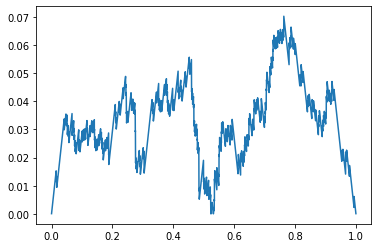

In [3]:
msft = pd.read_csv("https://raw.githubusercontent.com/krzysztof-kowalski/smf/main/msft_us_d.csv") #kurs MSFT 01-03-2016 do 01-03-2017
msft['Date'] = pd.to_datetime(msft['Date'])
logreturns_msft =  np.log(np.array(msft.iloc[1:, 1])) - np.log(np.array(msft.iloc[:(len(msft)-1),1])) #zwroty logarytmiczne, ceny z otwarcia
def sm(p,returns): #estymacja s i m przy ustalonym p
  e = np.mean(returns)
  v = np.mean(returns**2) - e**2
  m = np.sqrt(v/(4*p*(1-p)))
  s = e - m*(2*p -1)
  return s,m


def p_est(p,returns): #estymacja p przy użyciu (*)
  (s,m) = sm(p,returns)
  return np.count_nonzero(np.abs(returns - (s+m)) < np.abs(returns - (s-m)))/len(returns)

def p_opt(N,returns):
  p = np.array(range(1,N))/N
  p_fit = np.zeros(N-1)
  for i in range(0,N-1):
    p_fit[i] = np.abs(p[i] - p_est(p[i],returns))
  plt.plot(p,p_fit)
  return p[np.where(p_fit == np.amin(p_fit))]

p = p_opt(10000,logreturns_msft)
(s,m) = sm(p,logreturns_msft)
print(f"p = {p[0].round(decimals=5)}\ns = {s[0].round(decimals=5)}\nm = {m[0].round(decimals=5)}")

### Teoria do wyceny opcji

Potrzeba wyliczonych:
- $q$ - miara mtg, że $w_i = 1$
- $s, m$ - z kalibracji modelu
 

Otoczka Snella dana wzorami
\begin{align}
U_T &= H_T \\
U_{t} &= \max( H_t, \mathbb{E^*}[U_{t+1} | \mathcal{F}_t])
\end{align}
Rozkład Dooba $ U_t = M_t - A_t $, gdzie $M_t$ - adaptowalny martyngał, a $A_t$ - przewidywalny. Dane wzorami
\begin{align}
A_0 &= 0, \\ 
A_t &= A_{t-1} + U_{t-1} - \mathbb{E^*}[U_t | \mathcal{F}_{t-1}]
\end{align}
oraz 
$$
M_t = U_t + A_t.
$$

Wtedy rzeczywiście, 
- $A_t$ jest przewidywalny 
- $M_t$ jest martyngałem:

\begin{align}
 \mathbb{E^*}[M_t | \mathcal{F}_{t-1}] &= \mathbb{E^*}[U_t | \mathcal{F}_{t-1}] + \mathbb{E^*}[A_t | \mathcal{F}_{t-1}] = \mathbb{E^*}[U_t | \mathcal{F}_{t-1}] + A_t = \\
 &= \mathbb{E^*}[U_t | \mathcal{F}_{t-1}] + A_{t-1} + U_{t-1} - \mathbb{E^*}[U_t | \mathcal{F}_{t-1}] =
  M_{t-1}.
 \end{align}



### Uwagi odnośnie praktycznej wyceny na komputerze.

W naszym modelu, drzewko ceny aktywa podstawowego ma rozmiar wykładniczy (poza liśćmi, każdy wierzchołek ma dwóch synów). Jednak na cenę aktywa podstawowego $S_t$ w chwili $t$ wpływa tylko liczba wzrostów = $|\{ i : w_i = 1\}|$  oraz spadków  = $|\{ i : w_i = -1\}|$  do chwili $t$, a nie ich kolejność. Zatem aby wyceniać opcje, które nie zależą od trajektorii, możemy utożsamić wierzchołki o tej samej cenie aktywa podstawowego. Otrzymujemy dzięki temu drzewko o kwadratowej liczbie wierzchołków. Takie drzewko nazwiemy rekombinującym się.

Bez problemu wyliczmy procesu $U_t$ na rekombinującym się drzewku. Pojawia się jednak problem przy wyliczeniu procesu $A_t$. Przypomnijmy, 

$$
A_t = A_{t-1} + U_{t-1} - \mathbb{E^*}[U_t | \mathcal{F}_{t-1}].
$$
Czyli $A_t$ zależy od $A_{t-1}$, którego w drzewku rekombinującym nie znamy! Aby obejść ten problem będziemy liczyć proces roźnic dla procesu $A_t.$ Dokładniej, niech
$$
K_t := A_{t+1} - A_t = U_t - \mathbb{E^*}[U_{t+1} | \mathcal{F}_{t}] = \max( H_t - \mathbb{E^*}[U_{t+1} | \mathcal{F}_t], 0),
$$
zdefiniowany dla $t = 0 \dots T-1$.


### Optymalne czasy wykonania opcji: $\tau_\min$ i $\tau_\max.$

Najwcześniejszy optymalny czas wykonania $\tau_\min$ wyraża się poprzez
$$
\tau_\min = \inf \{ t \geq 0 | U_t = H_t \}.
$$

Najpóźniejszy optymalny czas zatrzymania $\tau_{\max}$ wyraża się poprzez $K_t$. Mianowicie:
$$
\tau_\max = \inf \{ t \geq 0 | A_{t+1} \neq 0  \} \vee T = \inf \{ t \geq 0 | K_{t} \neq 0  \} \vee T. 
$$


Poniżej dwa przykłady ww. procesów.

#### Przykłady 

1. Standardowa opcja amerykańska put.
![](https://raw.githubusercontent.com/wfica/stochastic-fin-maths/main/project_2/ex1_put.png)


1. Opcja amerykańska put z twistem.
![](https://raw.githubusercontent.com/wfica/stochastic-fin-maths/main/project_2/ex2_put%2Btwist.png)

In [176]:
TRAIN_START = np.min(msft['Date'])
TRAIN_END = np.max(msft['Date'])


CONST_R = 0.001

CONST_P = 0.5238
CONST_S = 0.00045559
CONST_M = 0.01174441
TAU_MAX = 'TAU_MAX' #f"\u03C4_MAX"
TAU_MIN = 'TAU_MIN' #f"\u03C4_MIN"

def GetMartingaleMeasure(r, s, m): #returns q
  return (np.exp(r-s) - np.exp(-1*m))/(np.exp(m) - np.exp(-1*m))


CONST_Q = GetMartingaleMeasure(CONST_R, CONST_S, CONST_M)
print(f"q = {CONST_Q}")

q = 0.5202471179566829


### Jak rozszerzyć model o dywidendy?

- GOOG: nie wypłaca dywidend
- MSFT: wypłaca *przewidywalne* wydidendy

In [ ]:
def GetMstfDividendsData():
  auth.authenticate_user()
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  worksheet = gc.open('MSFT dividends').sheet1
  rows = worksheet.get_all_values()
  msft_dividends = pd.DataFrame(rows[1:], columns=rows[0])
  for date_type in {'decl_date', 'ex_date', 'paid_date'}:
    msft_dividends[date_type] = pd.to_datetime(msft_dividends[date_type])
  return msft_dividends

In [ ]:
msft_dividends = GetMstfDividendsData()

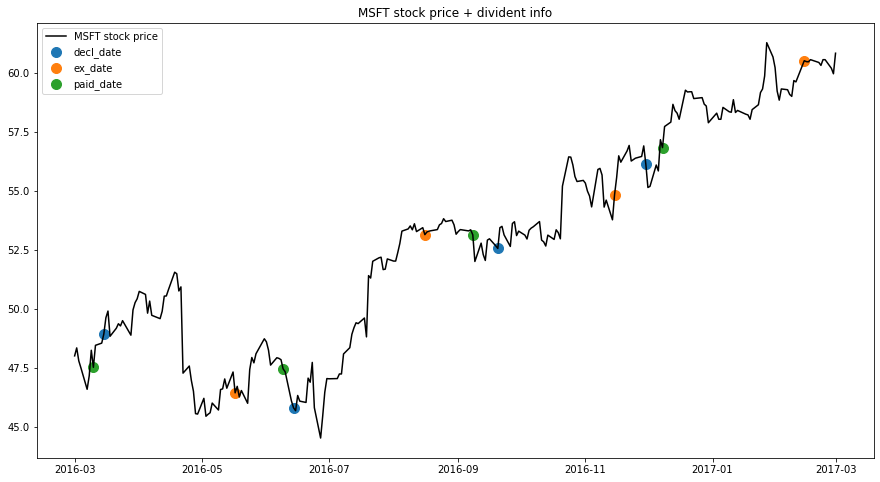

In [ ]:
figure(figsize=(15, 8))

plt.plot(msft['Date'], msft['Close'], label='MSFT stock price', color='black')

for date_type in ['decl_date', 'ex_date', 'paid_date']:

  df = msft_dividends[(msft_dividends[date_type] >= TRAIN_START) &(msft_dividends[date_type] <= TRAIN_END)]
  df = df.rename(columns={date_type: 'Date'})
  df = df.join( msft.set_index('Date'), on='Date', how='inner')
  plt.scatter(df['Date'], df['Close'], label=date_type, s=100)

plt.title('MSFT stock price + divident info')
plt.legend()


In [ ]:
%precision %.2f
for date_type in ['decl_date', 'ex_date', 'paid_date']:
  print(date_type)
  df = msft_dividends[(msft_dividends[date_type] >= TRAIN_START) &(msft_dividends[date_type] <= TRAIN_END)]
  df = df.rename(columns={date_type: 'Date'})
  df = msft.join( df.set_index('Date'), on='Date', how='inner')
  for i in list([df.index-1][0] ):
    diff = msft.loc[i+1]['Close'] - msft.loc[i]['Close']
    ratio = 100* diff /  msft.loc[i]['Close']
    print("date: ", msft.loc[i]['Date'], " diff: ", np.round(diff, 2), " ratio: ", np.round(ratio, 2))
    # print("date: ", msft.loc[i]['Date'], " before: ", msft.loc[i]['Close'], " after: ", msft.loc[i+1]['Close'], " diff: ", diff)
  # print( msft.loc[list([df.index-1][0] ) ])


decl_date
date:  2016-03-14 00:00:00  diff:  0.38  ratio:  0.79
date:  2016-06-13 00:00:00  diff:  -0.29  ratio:  -0.62
date:  2016-09-19 00:00:00  diff:  -0.11  ratio:  -0.21
date:  2016-11-29 00:00:00  diff:  -0.77  ratio:  -1.36
ex_date
date:  2016-05-16 00:00:00  diff:  -0.88  ratio:  -1.86
date:  2016-08-15 00:00:00  diff:  -0.29  ratio:  -0.55
date:  2016-11-14 00:00:00  diff:  1.06  ratio:  1.98
date:  2017-02-13 00:00:00  diff:  0.23  ratio:  0.38
paid_date
date:  2016-03-09 00:00:00  diff:  -0.72  ratio:  -1.5
date:  2016-06-08 00:00:00  diff:  -0.38  ratio:  -0.8
date:  2016-09-07 00:00:00  diff:  -0.22  ratio:  -0.4
date:  2016-12-07 00:00:00  diff:  -0.34  ratio:  -0.59


## Wycena Opcji

In [275]:
class OptionType(Enum):
  AMERICAN_CALL = auto()
  AMERICAN_PUT = auto()

class Option:
  def __init__(self, type, days_till_expiry, threshold, under_asset_name):
    """
    Args: 
      - type one of OptionType
      - days_till_expiry
      - threshold
    """
    self.type = type
    self.days_till_expiry = days_till_expiry
    self.threshold = threshold
    self.under_asset_name = under_asset_name
    if self.type == OptionType.AMERICAN_CALL:
      self.payoff = lambda x : max(x - self.threshold, 0)
    elif self.type == OptionType.AMERICAN_PUT:
      self.payoff = lambda x : max(self.threshold - x, 0)
    else: 
      raise Exception(f"Unknown option type: {self.type}.")

  def Payoff(self, s):
    return self.payoff(s)

  def __str__(self):
    return f"{self.type.name} on {self.under_asset_name} @ {self.threshold}, expiry in {self.days_till_expiry} days."

  
def _on_board(i, j):
  return i >= 0 and j >= 0 and j <= i

def _get_info(prev_i, prev_j, i, j, U, H, K, eps=1e-9):
  if not _on_board(prev_i, prev_j):
    return None
  if abs(K[prev_i][prev_j]) < eps and K[i][j] > 0:
    return TAU_MAX
  if U[prev_i][prev_j] >  H[prev_i][prev_j] and U[i][j] == H[i][j]:
    return TAU_MIN
  return None

def VanillaAmericanOptionStats(q, s, m, r, tdy_asset_price, option):
  """
  Args:
    - q - miara mtg, że w_i = 1
    - s, m, r - z kalibracji modelu
    - tdy_asset_price - dzisiejsza cena instrumentu podstawowego
    - option - opcja do wyceny
  Returns:
    - S[][] - drzewko cen aktywa bazowego: tablica trójkątna: S[n = numer_dnia][liczba w_i == 1 dla i \in {0, 1, ..., n} ].
    - U[][] - otoczka Snella; tablica trójkątna jak wyżej.
    - K[][] - przyrosty procesu przewidywalnego z rozkładu Dooba -  tablice trójkątna wymiaru (n-1) x (n-1)
    - Opt[][] - optymalne czasy wykonania - tablica True/ False; tablica trójkątna jak wyżej wymiaru (n-1) x (n-1)
    - days[][] - numery dnia dopowiadajace indeksom tj. days[i][j] = i
    - df - pandas.DataFrame days, S, U, K w 'long format' - na potrzeby wykresów
  """
  N = option.days_till_expiry + 1
  S = np.zeros((N, N))
  S[0][0] = tdy_asset_price
  U = np.zeros_like(S)
  H = np.zeros_like(S)
  K = np.zeros((N-1, N-1))
  Opt = np.zeros_like(K, dtype=bool)
  df_rows = []
  for i in range(1, N):
    S[i][0] = S[i-1][0] * np.exp(s - m)
    for j in range(1, i+1):
      S[i][j] = S[i-1][j-1]*np.exp(s + m)
  # W liściach, U[N-1][_] to zdyskontowany payoff.
  for i in range(0, N):
    U[N-1][i] = option.Payoff(S[N-1][i]) * np.exp(-r*(N-1))
    H[N-1][i] = U[N-1][i]
    df_rows.append({'day':N-1, 'S': S[N-1][i], 'U': U[N-1][i], 'K':None, 'K_positive' : None, 'U==H': True, 'info':TAU_MAX })

  # Wyliczamy pozostałe wartości U[][].
  for i in range(N-2, -1, -1):
    for j in range(0, i+1):
      cond_exp = q *  U[i+1][j+1] + (1.-q) * U[i+1][j]
      early_exercise = option.Payoff(S[i][j]) * np.exp(-r*i)
      H[i][j] = early_exercise
      U[i][j] = max(cond_exp, early_exercise)
      if early_exercise >= cond_exp:
        Opt[i][j] = True
      K[i][j] = U[i][j] - cond_exp


  for i in range(N-2, -1, -1):
    for j in range(0, i+1):
      info = _get_info(i-1, j-1, i, j, U, H, K)
      if info is None:
        info = _get_info(i-1, j, i, j, U, H, K)
      df_rows.append({'day':i, 'S': S[i][j], 'U': U[i][j], 'K':K[i][j], 'K_positive' : K[i][j] > 0, 'U==H': U[i][j] == H[i][j], 'info': info })
  
  days = np.arange(N)[None, :]
  days = np.tile(days.T, (1, N))

  df = pd.DataFrame(df_rows)
  df['K_positive'] = df['K_positive'].astype(str)
  df['U==H'] = df['U==H'].astype(str)
  df['info'] = df['info'].astype(str)

  df['S_log'] = np.log(df['S'])

  return S, U, K, Opt, days, df


Będziemy rozważać opcje
- AC(GOOG, 900)
- AP(GOOG, 900)
- AC(MSTF, 60)
- AP(MSTF, 60)
- Barierowa bermudzka opcja put na MSTF z kursem wykoanania 60 i barierą typu *down-and-out* o wartości 45, którą można wykonać w dniach 01-06-2017, 01-09-2017, 01-12-2017, 01-03-2018.

In [287]:
NUM_TR_DAYS = 200
options = [ Option(OptionType.AMERICAN_CALL, NUM_TR_DAYS, 900, 'GOOG'), 
           Option(OptionType.AMERICAN_PUT, NUM_TR_DAYS, 900, 'GOOG')]

In [288]:
option = options[1]
print(option)
S, U, K, Opt, days, df = VanillaAmericanOptionStats(CONST_Q, CONST_S, CONST_M, CONST_R, 1000, option)

AMERICAN_PUT on GOOG @ 900, expiry in 200 days.


In [289]:
df['marker_size'] = (df['info'] != 'None').astype(int) + 1

In [290]:
df

day            S           U    K  ...   U==H     info     S_log  marker_size
0      200   104.584073  651.231481  NaN  ...   True  TAU_MAX  4.649991            2
1      200   107.069708  649.196415  NaN  ...   True  TAU_MAX  4.673480            2
2      200   109.614418  647.112983  NaN  ...   True  TAU_MAX  4.696969            2
3      200   112.219608  644.980033  NaN  ...   True  TAU_MAX  4.720458            2
4      200   114.886715  642.796391  NaN  ...   True  TAU_MAX  4.743947            2
...    ...          ...         ...  ...  ...    ...      ...       ...          ...
20296    2  1000.911595    3.641103  0.0  ...  False     None  6.908666            1
20297    2  1024.700116    2.408933  0.0  ...  False     None  6.932155            1
20298    1   988.774660    4.506177  0.0  ...  False     None  6.896466            1
20299    1  1012.274724    3.000070  0.0  ...  False     None  6.919955            1
20300    0  1000.000000    3.722629  0.0  ...  False     None  6.907755            1

[20301 rows x 9 columns]

In [291]:
df.loc[20165]

day                  15
S               844.228
U               54.9413
K              0.408071
K_positive         True
U==H               True
info            TAU_MAX
S_log           6.73842
marker_size           2
Name: 20165, dtype: object

In [292]:
df.loc[20181]

day                 14
S              853.813
U              46.3503
K                    0
K_positive       False
U==H             False
info              None
S_log          6.74971
marker_size          1
Name: 20181, dtype: object

In [293]:
px.scatter(df, x='day', y='S', opacity=0.7, color='K_positive', color_discrete_map = {'True': 'darkorange', 'False': 'green'}, hover_data=['K', 'S'], title=str(option), log_y=True)

In [294]:
px.scatter_3d(df, x = 'day', y='S', z = 'K', opacity=0.7, color='K', title=str(option))

In [295]:
px.scatter(df, x='day', y='S', opacity=0.7, color='U==H', color_discrete_map = {'True': 'darkorange', 'False': 'green'}, hover_data=['K', 'S'], title=str(option), log_y=True)

In [297]:
px.scatter(df, x='day', y='S', color='info', hover_data=['K', 'S'], title=str(option), log_y=True,opacity=0.3, color_discrete_map = {TAU_MAX: 'black', TAU_MIN: 'green', 'None':'orange'  })

In [285]:
def _set_opacity(info):
  return 0.2 if info == 'None' else 1.0

def _set_color(info):
  if info == TAU_MAX:
    return 'black'
  if info == TAU_MIN:
    return 'green'
  return 'orange'

fig = go.Figure(data=[go.Scatter(
    x=df['day'],
    y=df['S'],
    mode='markers',
    marker=dict(
        color=list(map(_set_color, df['info'])),             
        # color_discrete_map = {TAU_MAX: 'black', TAU_MIN: 'green', 'None':'orange'},
        opacity=list(map(_set_opacity, df['info']) )
    )
)])
fig.update_layout(title = str(option), xaxis_title='day', yaxis_title='S')
fig.update_yaxes(type='log')

# tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

In [161]:
option = options[0]
print(option)
S, U, K, Opt, days, df = VanillaAmericanOptionStats(CONST_Q, CONST_S, CONST_M, CONST_R, 1000, option)

AMERICAN_CALL on GOOG @ 900, expiry in 200 days.


In [162]:
px.scatter(df, x='day', y='S', opacity=0.7, color='K_positive', color_discrete_map = {'True': 'darkorange', 'False': 'green'}, hover_data=['K', 'S'], title=str(option), log_y=True)

# PLAYGROUND

In [ ]:
%precision 2
u


(array([[1.00e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [1.35e+00, 5.46e+02, 0.00e+00, 0.00e+00, 0.00e+00],
        [1.83e-01, 7.39e+01, 2.98e+04, 0.00e+00, 0.00e+00],
        [2.48e-02, 1.00e+01, 4.03e+03, 1.63e+06, 0.00e+00],
        [3.35e-03, 1.35e+00, 5.46e+02, 2.20e+05, 8.89e+07]]),
 array([[0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 3.53e-01, 5.45e+02, 2.20e+05, 8.89e+07]]))

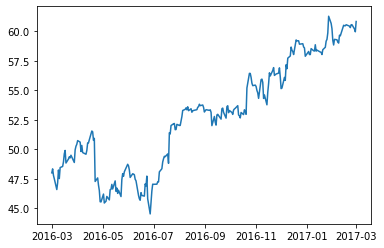

In [ ]:

plt.plot(msft['Date'], msft['Close'])

In [ ]:
# msft_dividends  = pd.DataFrame({
#     'Decl_Date':['2016-03-15', '2016-06-14', '2016-11-30', '2017-03-14' ], 
#     'Ex_Date':['2016-05-17', '2016-08-16', '2017-02-14', '2017-05-16'], 
#     'Pay_Date':['2016-06-09', '2016-09-08', '2017-03-09', ], 
#     'Amount':[0.36, 0.4, ]})
# msft_dividends

Decl_Date     Ex_Date    Pay_Date  Amount
0  2016-03-15  2016-05-17  2016-06-09    0.36